In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import numpy as np
import os

from Software.GenuVP import runGNVP as gnvp

from PlaneDefinition.plane import Airplane as Plane
from PlaneDefinition.wing import Wing as wg
import PlaneDefinition.wing as wing

from Database.getresults import Database_2D
from Database import DB3D , BASEGNVP
from Visualization import plotting as aplt

from Airfoils import airfoil as af


In [3]:
HOMEDIR = os.getcwd()

# Airfoil Data

In [4]:
db = Database_2D(HOMEDIR)
airfoils = db.getAirfoils()
polars = db.Data

# Get Plane

In [5]:
Origin = np.array([0., 0., 0.])

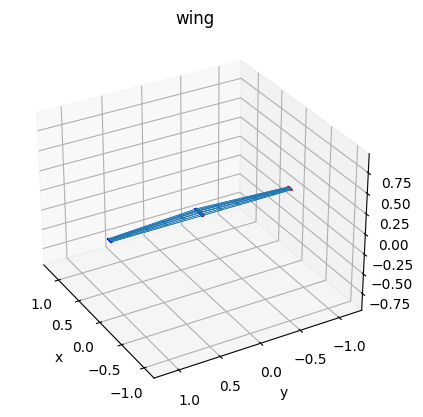

In [6]:
wingPos = np.array([0.0,0.0,0.0])
wingOrientation = np.array([0.0,0.0,0.0])

mainWing = wg(name="wing",
              airfoil=airfoils['NACA4415'],
              Origin=Origin + wingPos,
              Orientation=wingOrientation,           
              isSymmetric=True,
              span=2 * 1.130,
              sweepOffset=0,
              dihAngle=0,
              chordFun=wing.linearChord,
              chord=[0.159, 0.072],
              spanFun=wing.linSpan,
              N = 6,
              M = 5,
              mass = 0.670)
mainWing.plotWing()

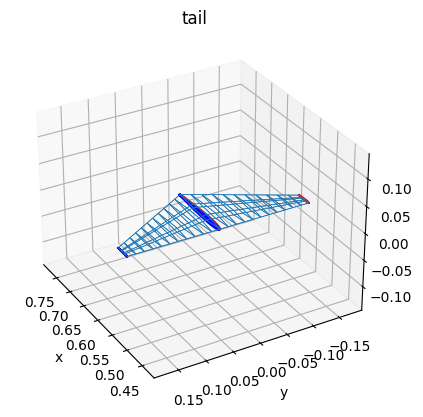

In [7]:
elevatorPos = np.array([0.54,0.,0.])
elevatorOrientantion = np.array([0.,0.,0.])

elevator = wg(name = "tail",
              airfoil=airfoils['NACA0008'],
              Origin=Origin+ elevatorPos,
              Orientation=elevatorOrientantion,
              isSymmetric=True,
              span= 2 * 0.169,
              sweepOffset=0,
              dihAngle=0,
              chordFun=wing.linearChord,
              chord=[0.130, 0.03],
              spanFun=wing.linSpan,
              N = 12,
              M = 4,
              mass = 0.06)
elevator.plotWing()

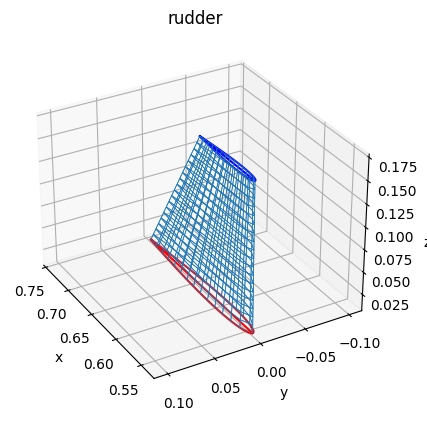

In [8]:
rudderPos = np.array([0.54, 0., 0.01])
rudderOrientantion = np.array([0.0,0.0,90.0])

rudder = wg(name= "rudder",
            airfoil=airfoils['NACA0008'],
            Origin=Origin + rudderPos,
            Orientation= rudderOrientantion,
            isSymmetric=False,
            span= 0.165,
            sweepOffset=0,
            dihAngle=0,
            chordFun=wing.linearChord,
            chord=[0.2, 0.1],
            spanFun=wing.linSpan,
            N = 19,
            M = 15,
            mass = 0.04)
rudder.plotWing()

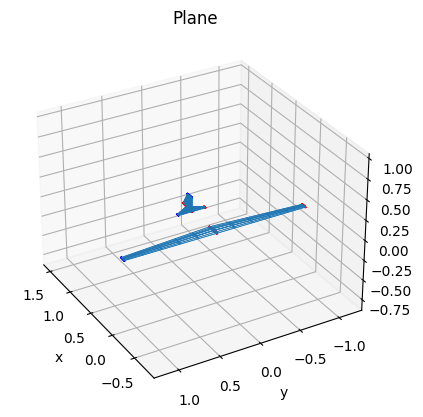

In [9]:
liftingSurfaces = [mainWing, elevator, rudder]
ap = Plane("Plane",liftingSurfaces)
ap.accessDB(HOMEDIR,DB3D)
ap.visAirplane()

In [10]:
cleaning = False
calcGenu = True
calcBatchGenu = True

## Batch Run

In [11]:
AoAmax = 15
AoAmin = -6
NoAoA = (AoAmax - AoAmin) + 1
angles = np.linspace(AoAmin, AoAmax, NoAoA)

Uinf = 20

In [12]:
# ap.batchangles(angles)
# if calcBatchGenu == True:
#     genuBatchArgs = [ap, BASEGNVP, polars,"Xfoil",Uinf, angles]
#     ap.runSolver(gnvp.runGNVP,genuBatchArgs)
